Loading Data from Kaggle Datasets


In [0]:
from google.colab import files

#!pip install -q kaggle

In [13]:
cd .kaggle

/root/.kaggle


In [16]:
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [21]:
ls

sample_data/


In [22]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 98% 1.13G/1.15G [00:10<00:00, 119MB/s]
100% 1.15G/1.15G [00:10<00:00, 115MB/s]


In [0]:
!chmod 600 /root/.kaggle/kaggle.json

test/  train/  val/


Extracting the images from the zip file


In [0]:
import zipfile
with zipfile.ZipFile("chest-xray-pneumonia.zip") as zip_ref:
  zip_ref.extractall()

In [0]:
with zipfile.ZipFile("chest_xray.zip") as zip_ref:
  zip_ref.extractall()

Importing the required libraries

In [0]:
import tensorflow as tf
import keras
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import cv2
from PIL import Image
from tqdm import tqdm
import os
from keras.applications.inception_v3 import inception_v3
from sklearn.preprocessing import LabelEncoder

In [40]:
print(os.listdir('../content/chest_xray/'))
TRAIN_NORMAL_DIR = '../content/chest_xray/train/NORMAL'
TRAIN_PNEUM_DIR = '../content/chest_xray/train/PNEUMONIA'
TEST_NORMAL_DIR = '../content/chest_xray/test/NORMAL'
TEST_PNEUM_DIR = '../content/chest_xray/test/PNEUMONIA'
VAL_NORMAL_DIR = '../content/chest_xray/val/NORMAL'
VAL_PNEUM_DIR = '../content/chest_xray/val/PNEUMONIA'

['train', 'test', 'val', '.DS_Store']


Loading the images and converting them into numpy arrays

In [0]:
X_train = []
X_test = []
X_val = []
y_train = []
y_test = []
y_val = []

def convert_images(dir, categ):
  for img in tqdm(os.listdir(dir)):
    if (img == '.DS_Store'):
      continue;
    path = os.path.join(dir, img)
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (150, 150))
    if (dir.find('train') >= 0):
      X_train.append(np.array(img))
      y_train.append(categ)
    elif (dir.find('test') >= 0):
      X_test.append(np.array(img))
      y_test.append(categ)
    else:
      X_val.append(np.array(img))
      y_val.append(categ)

convert_images(TRAIN_NORMAL_DIR, "normal");
convert_images(TRAIN_PNEUM_DIR, "pneumonia");
convert_images(TEST_NORMAL_DIR, "normal");
convert_images(TEST_PNEUM_DIR, "pneumonia");
convert_images(VAL_NORMAL_DIR, "normal");
convert_images(VAL_PNEUM_DIR, "pneumonia");


In [0]:
X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)
y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)

In [65]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(5216, 150, 150, 3)
(624, 150, 150, 3)
(16, 150, 150, 3)
(5216,)
(624,)
(16,)


Rescaling X data and performing one-hot encoding on y data 


In [0]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)
y_val = le.fit_transform(y_val)

In [0]:
X_train = X_train/255
X_test = X_test/255
X_val = X_val/255

Visualizing some of the x-rays

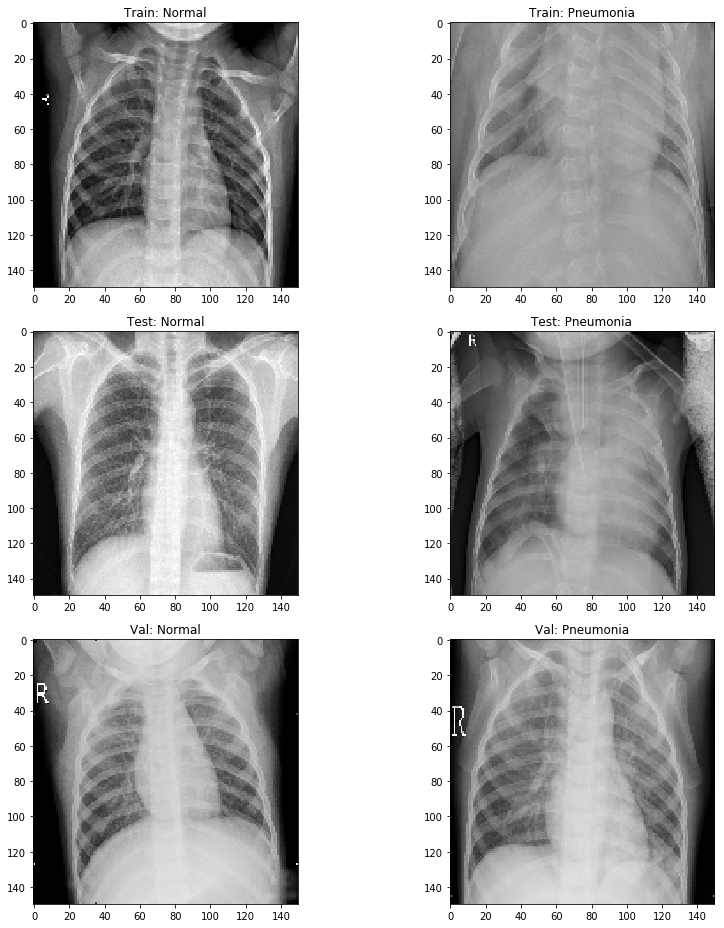

In [96]:
fig, ax = plt.subplots(3, 2)
fig.set_size_inches(13, 13)

ax[0, 0].imshow(X_train[0])
ax[0, 0].set_title("Train: "+("Pneumonia" if y_train[0] else "Normal"))
ax[1, 0].imshow(X_test[0])
ax[1, 0].set_title("Test: "+("Pneumonia" if y_test[0] else "Normal"))
ax[2, 0].imshow(X_val[0])
ax[2, 0].set_title("Val: "+("Pneumonia" if y_val[0] else "Normal"))

ax[0, 1].imshow(X_train[-1])
ax[0, 1].set_title("Train: "+("Pneumonia" if y_train[-1] else "Normal"))
ax[1, 1].imshow(X_test[-1])
ax[1, 1].set_title("Test: "+("Pneumonia" if y_test[-1] else "Normal"))
ax[2, 1].imshow(X_val[-1])
ax[2, 1].set_title("Val: "+("Pneumonia" if y_val[-1] else "Normal"))

plt.tight_layout()